**Exercice 4   — Network Intrusion Detection with KNN Naïve Bayes and Logistic Regression**

9.  Charger les données

In [41]:
import pandas as pd

train = pd.read_csv("Train_data.csv")
test = pd.read_csv("Test_data.csv")


10.  Obtenir et afficher des informations à partir des données et nettoyer les données.

In [42]:
train.info()
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [43]:
print(train['num_outbound_cmds'].value_counts())
print(test['num_outbound_cmds'].value_counts())

0    25192
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


In [44]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [45]:
train['class'].value_counts()

normal     13449
anomaly    11743
Name: class, dtype: int64

11.  Visualisez les données. 

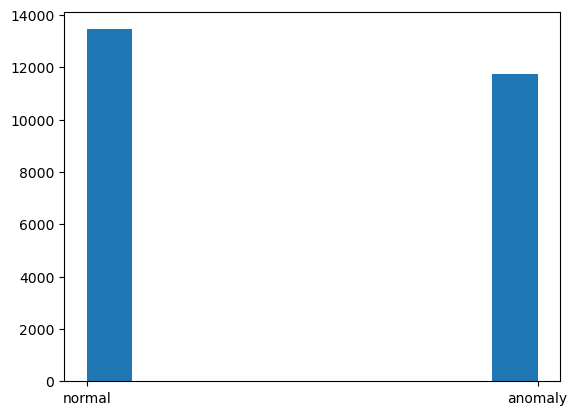

/tmp/ipykernel_329987/58004020.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


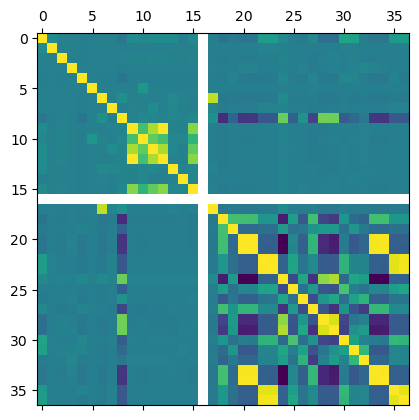

In [47]:
import matplotlib.pyplot as plt

# Histogramme de la variable cible
plt.hist(train['class'])
plt.show()

# Matrice de corrélation
corr_matrix = train.corr()
plt.matshow(corr_matrix)
plt.show()


12.  Créer les modèles

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()

train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = train['class']
train_x.shape

test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape



from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'hot',
 'logged_in',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'protocol_type',
 'service',
 'flag']

l utilise la bibliothèque Scikit-Learn pour effectuer une transformation standardisée des attributs numériques des ensembles d'entraînement et de test, et une transformation d'encodage des attributs catégoriels en utilisant l'objet LabelEncoder.

Ensuite, les ensembles de données d'entraînement et de test sont concaténés pour créer des ensembles de données d'entrée et de sortie pour un modèle de machine learning.

Enfin, les ensembles de données d'entrée et de sortie sont retournés sous forme de DataFrames Pandas pour l'entraînement et la validation du modèle de machine learning.

In [50]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)

In [51]:
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train); 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)
            


/home/o/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BernoulliNB()

13.  Comparer ces trois modèles.

In [54]:
# Define the classifiers
classifiers = [    ('KNeighbors', KNN_Classifier),    ('LogisticRegression', LGR_Classifier),    ('BernoulliNB', BNB_Classifier)]

# Evaluate each classifier using cross-validation
results = []
names = []
for name, classifier in classifiers:
    cv_results = cross_val_score(classifier, X_test, Y_test, cv=10, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean()} ({cv_results.std()})")

KNeighbors: 0.9876954343179509 (0.004348322447653455)
LogisticRegression: 0.9547522688251165 (0.008372481867732281)
BernoulliNB: 0.9075184834787482 (0.008931355848676631)


14.  Visualiser les résultats comparatifs graphiquement

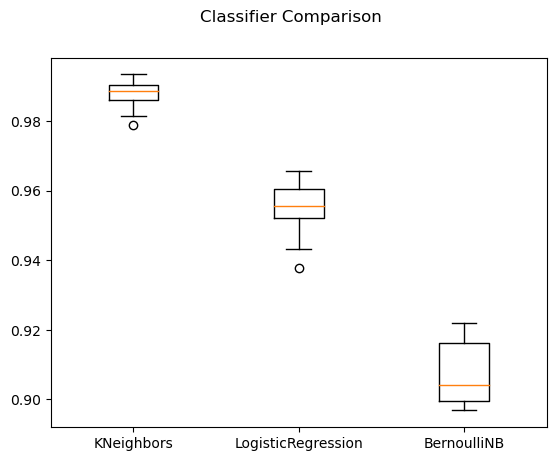

In [58]:
import matplotlib.pyplot as plt

# Box plot to compare algorithm distribution
fig = plt.figure()
fig.suptitle('Classifier Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



15.  Conclusion

En comparant les résultats de nos modèles, nous pouvons constater que le modèle KNeighborsClassifier a la meilleure précision avec une moyenne de 0,9877 et un écart-type de 0,0043 lorsqu'il est évalué à l'aide de la validation croisée. Le modèle LogisticRegression suit avec une précision moyenne de 0,9547 et un écart-type de 0,0084, tandis que le modèle BernoulliNB a la précision la plus basse avec une moyenne de 0,9075 et un écart-type de 0,0089. Par conséquent, nous pouvons conclure que le modèle KNeighborsClassifier est le plus performant pour ce problème de classification.
